In [1]:
# Packages loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore");
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, make_scorer, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, average_precision_score, f1_score

In [3]:
# Loading the dataset
reviews = pd.read_csv('/Users/louiserigal/Documents/Data Science/Portfolio/Text Review/Womens Clothing E-Commerce Reviews.csv')
reviews = reviews.drop('Unnamed: 0', axis = 1)

In [5]:
# Overview of the data
reviews.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [7]:
# Take-away lessons from our exploratory part
# The variable 'Recommended IND', which can be considered as our DV, is greatly imbalanced between its modes (1: recommended, 0: not recommended)
# Several methods to take into account these imbalance in our models are shown below (class_weight = 'balanced', Under and Oversampling
# We will also explore the difference in results of our models between using CountVectorizer (count of words) and TF-IDF Vectorizer 
# (Weighted scores based on frequency and uniqueness).
# to convert text data into numerical representations (vectors)

Reviews Text - Cleaning

In [10]:
reviews_wna = reviews.dropna(subset = 'Review Text').reset_index()
print(reviews_wna.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22641 entries, 0 to 22640
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    22641 non-null  int64 
 1   Clothing ID              22641 non-null  int64 
 2   Age                      22641 non-null  int64 
 3   Title                    19675 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   22641 non-null  int64 
 6   Recommended IND          22641 non-null  int64 
 7   Positive Feedback Count  22641 non-null  int64 
 8   Division Name            22628 non-null  object
 9   Department Name          22628 non-null  object
 10  Class Name               22628 non-null  object
dtypes: int64(6), object(5)
memory usage: 1.9+ MB
None


In [12]:
# Functions to observe our results

def visualisations(y_test, y_pred, y_proba) :
    plt.figure(figsize = (10,3))
    plt.subplot(121)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['No Recommended', 'Recommended'], yticklabels=['No Recommended', 'Recommended'])
    plt.xlabel('Prédictions')
    plt.ylabel('Observations')
    plt.title('Matrice de confusion')
    
    plt.subplot(122)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def prediction(model, X_train, y_train, X_test) :
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_proba

def evaluation_metrics(y_test, y_pred, y_proba) :
    print("\nClassification Report :")
    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))

def comparision_metrics(y_test, y_pred, y_proba) :
    model_Count_prec = average_precision_score(y_test, y_proba) # attention on voudra changer ça en 0
    model_Count_rec = recall_score(y_test, y_pred, pos_label = 0)
    model_Count_f1 = f1_score(y_test, y_pred, pos_label = 0)
    return model_Count_prec, model_Count_rec, model_Count_f1

In [14]:
# Initialisation
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

# Function to clean our texts
def text_cleaning(text_data):
    # Concat all our text
    #text_data = ' '.join(text_data)
    
    # Tokenisation
    tokens = word_tokenize(text_data.lower())  # Lower and tokenization in words
    
    # Filtrage des stopwords
    tsw = [word for word in tokens if word not in stop_words]

    # Lemmatisation
    lem = [wordnet_lemmatizer.lemmatize(word) for word in tsw]
    
    # Nettoyage caractère supplémentaires
    cleaned_tokens = [re.sub(r'[^\w\s]', '', word) for word in lem]
    
    # Suppression des tokens vides résultant du nettoyage
    cleaned_tokens = [word for word in cleaned_tokens if word.strip() != '']
    
    # Rejoindre les mots nettoyés en une chaîne
    cleaned_text = ' '.join(cleaned_tokens)
    
    # Rejoindre les mots nettoyés en une chaîne
    return cleaned_text # to have the words joined in a text

In [16]:
# Preprocessing of our reviews
X = reviews_wna['Review Text']
X_cleaned = X.apply(lambda row: text_cleaning(row))

ML SENTIMENT CLASSIFIER - Countvectorizer

In [18]:
# Preparation of our DV and IV
X = X_cleaned
y = reviews_wna['Recommended IND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

In [19]:
count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)

Logistic Regression - balanced


Classification Report :
              precision    recall  f1-score   support

           0       0.61      0.78      0.68       837
           1       0.95      0.89      0.91      3692

    accuracy                           0.87      4529
   macro avg       0.78      0.83      0.80      4529
weighted avg       0.88      0.87      0.87      4529

AUC-ROC: 0.9066621491655567


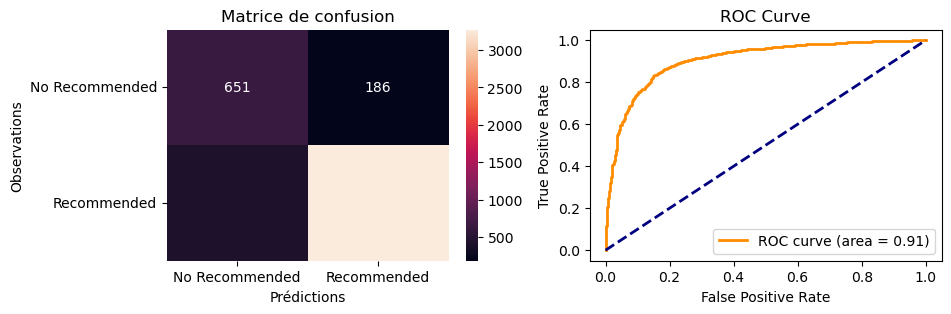

In [21]:
LR_Count = LogisticRegression(class_weight = 'balanced')
y_pred, y_proba = prediction(LR_Count, X_train, y_train, X_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

# comparision metrics
LR_Count_prec, LR_Count_rec, LR_Count_f1 = comparision_metrics(y_test, y_pred, y_proba)

SVM - balanced


Classification Report :
              precision    recall  f1-score   support

           0       0.73      0.46      0.56       837
           1       0.89      0.96      0.92      3692

    accuracy                           0.87      4529
   macro avg       0.81      0.71      0.74      4529
weighted avg       0.86      0.87      0.86      4529

AUC-ROC: 0.886574154974882


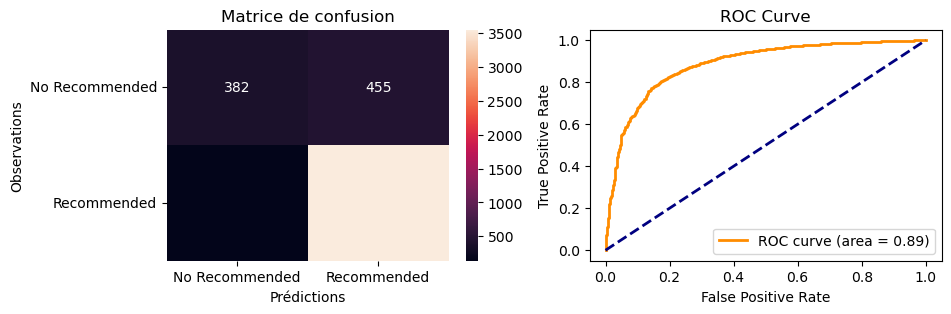

In [23]:
# SVM - errors made on 'Negative' reviews are more penalized than on 'Positive'
svm = LinearSVC(class_weight = 'balanced')
svm_Count = CalibratedClassifierCV(svm) 
y_pred, y_proba = prediction(svm_Count, X_train, y_train, X_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

# comparision metrics
svm_Count_prec, svm_Count_rec, svm_Count_f1 = comparision_metrics(y_test, y_pred, y_proba)

Random Forest - balanced


Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.23      0.36       837
           1       0.85      0.99      0.92      3692

    accuracy                           0.85      4529
   macro avg       0.86      0.61      0.64      4529
weighted avg       0.85      0.85      0.81      4529

AUC-ROC: 0.9140860926980873


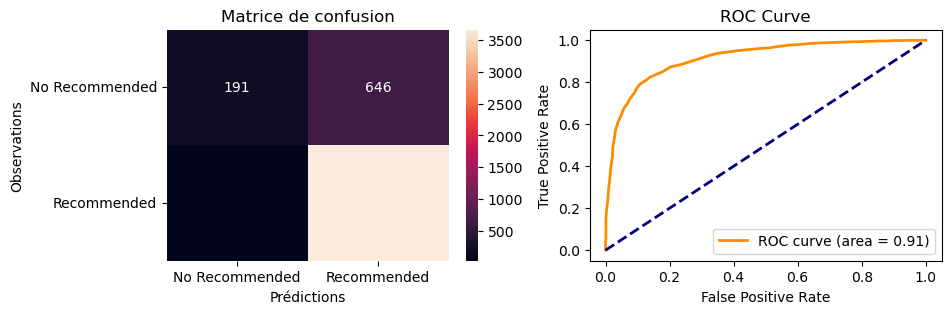

In [33]:
# Random Forest
RF_Count = RandomForestClassifier(class_weight = 'balanced')
y_pred, y_proba = prediction(RF_Count, X_train, y_train, X_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

# comparision metrics
RF_Count_prec, RF_Count_rec, RF_Count_f1 = comparision_metrics(y_test, y_pred, y_proba)

XGBoost


Classification Report :
              precision    recall  f1-score   support

           0       0.78      0.26      0.39       837
           1       0.85      0.98      0.91      3692

    accuracy                           0.85      4529
   macro avg       0.82      0.62      0.65      4529
weighted avg       0.84      0.85      0.82      4529

AUC-ROC: 0.8860531537723724


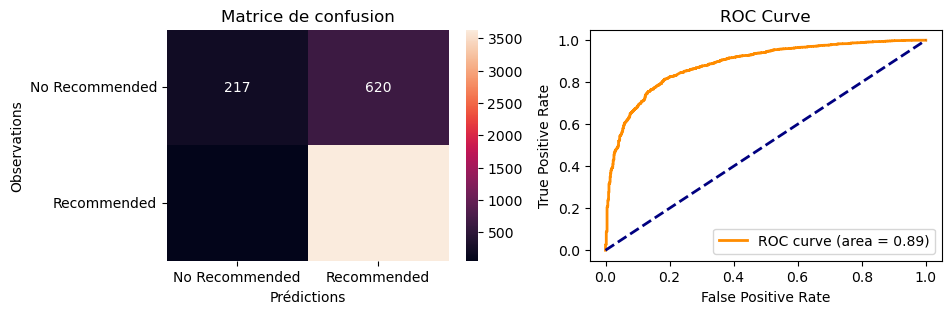

In [35]:
xgb_Count = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                              learning_rate=0.1, n_estimators=100, max_depth=3)
y_pred, y_proba = prediction(xgb_Count, X_train, y_train, X_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

# comparision metrics
xgb_Count_prec, xgb_Count_rec, xgb_Count_f1 = comparision_metrics(y_test, y_pred, y_proba)

ML SENTIMENT CLASSIFIER - TF-IDF

In [38]:
# Preparation of our DV and IV
X = X_cleaned
y = reviews_wna['Recommended IND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

In [40]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

Logistic Regression - balanced


Classification Report :
              precision    recall  f1-score   support

           0       0.58      0.84      0.69       837
           1       0.96      0.86      0.91      3692

    accuracy                           0.86      4529
   macro avg       0.77      0.85      0.80      4529
weighted avg       0.89      0.86      0.87      4529

AUC-ROC: 0.9266511207674315


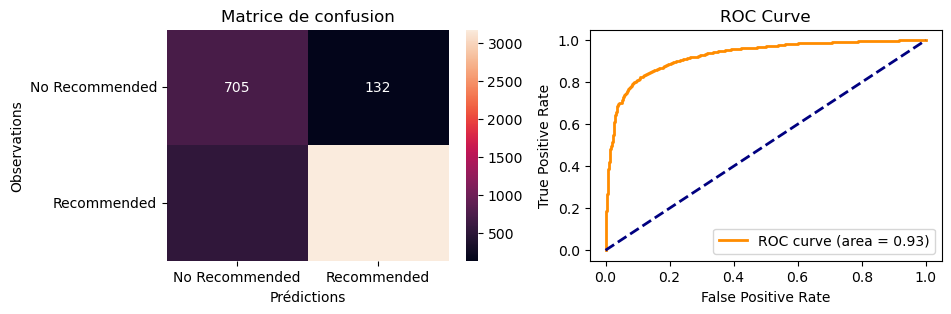

In [42]:
LR_Tfidf = LogisticRegression(class_weight = 'balanced')
y_pred, y_proba = prediction(LR_Tfidf, X_train, y_train, X_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

# comparision metrics
LR_Tfidf_prec, LR_Tfidf_rec, LR_Tfidf_f1 = comparision_metrics(y_test, y_pred, y_proba)

SVM - balanced


Classification Report :
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       837
           1       0.91      0.95      0.93      3692

    accuracy                           0.88      4529
   macro avg       0.81      0.76      0.78      4529
weighted avg       0.87      0.88      0.87      4529

AUC-ROC: 0.917307401064784


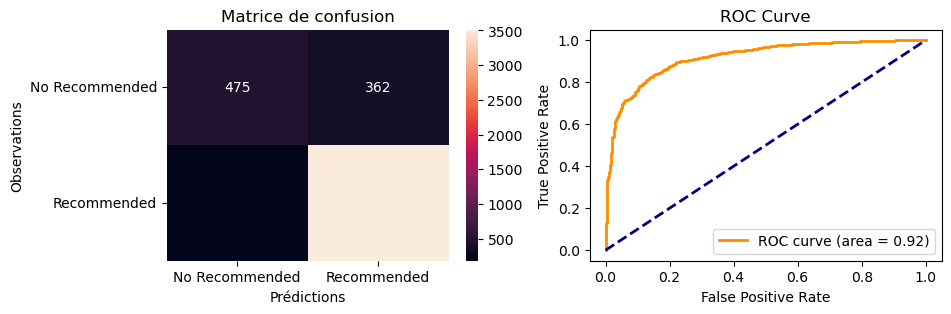

In [45]:
# SVM - errors made on 'Negative' reviews are more penalized than on 'Positive'
svm = LinearSVC(class_weight = 'balanced')
svm_Tfidf = CalibratedClassifierCV(svm) 
y_pred, y_proba = prediction(svm_Tfidf, X_train, y_train, X_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

# comparision metrics
svm_Tfidf_prec, svm_Tfidf_rec, svm_Tfidf_f1 = comparision_metrics(y_test, y_pred, y_proba)

Random Forest - balanced


Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.22      0.36       837
           1       0.85      0.99      0.92      3692

    accuracy                           0.85      4529
   macro avg       0.86      0.61      0.64      4529
weighted avg       0.85      0.85      0.81      4529

AUC-ROC: 0.9158751331627297


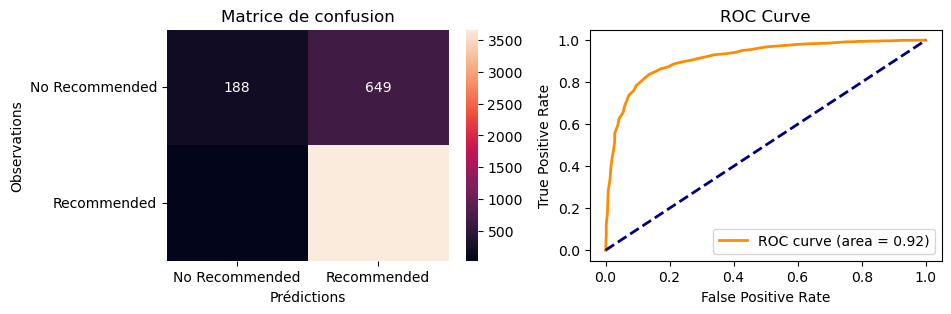

In [47]:
# Random Forest
RF_Tfidf = RandomForestClassifier(class_weight = 'balanced')
y_pred, y_proba = prediction(RF_Tfidf, X_train, y_train, X_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

# comparision metrics
RF_Tfidf_prec, RF_Tfidf_rec, RF_Tfidf_f1 = comparision_metrics(y_test, y_pred, y_proba)

XGBBoost


Classification Report :
              precision    recall  f1-score   support

           0       0.80      0.27      0.40       837
           1       0.86      0.99      0.92      3692

    accuracy                           0.85      4529
   macro avg       0.83      0.63      0.66      4529
weighted avg       0.85      0.85      0.82      4529

AUC-ROC: 0.8848325223836355


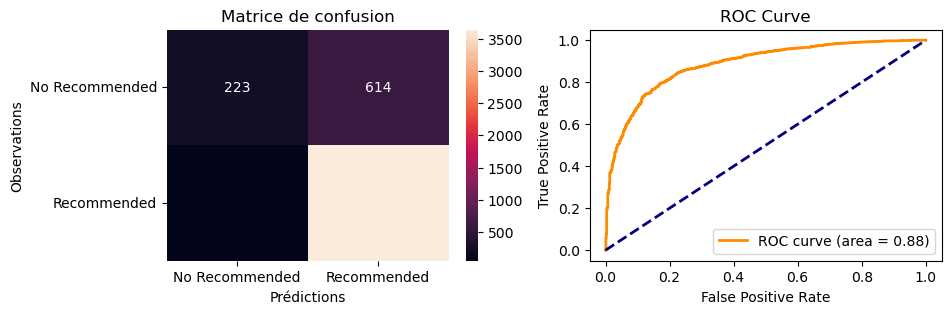

In [49]:
xgb_Tfidf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                              learning_rate=0.1, n_estimators=100, max_depth=3)
y_pred, y_proba = prediction(xgb_Tfidf , X_train, y_train, X_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

# comparision metrics
xgb_Tfidf_prec, xgb_Tfidf_rec, xgb_Tfidf_f1 = comparision_metrics(y_test, y_pred, y_proba)

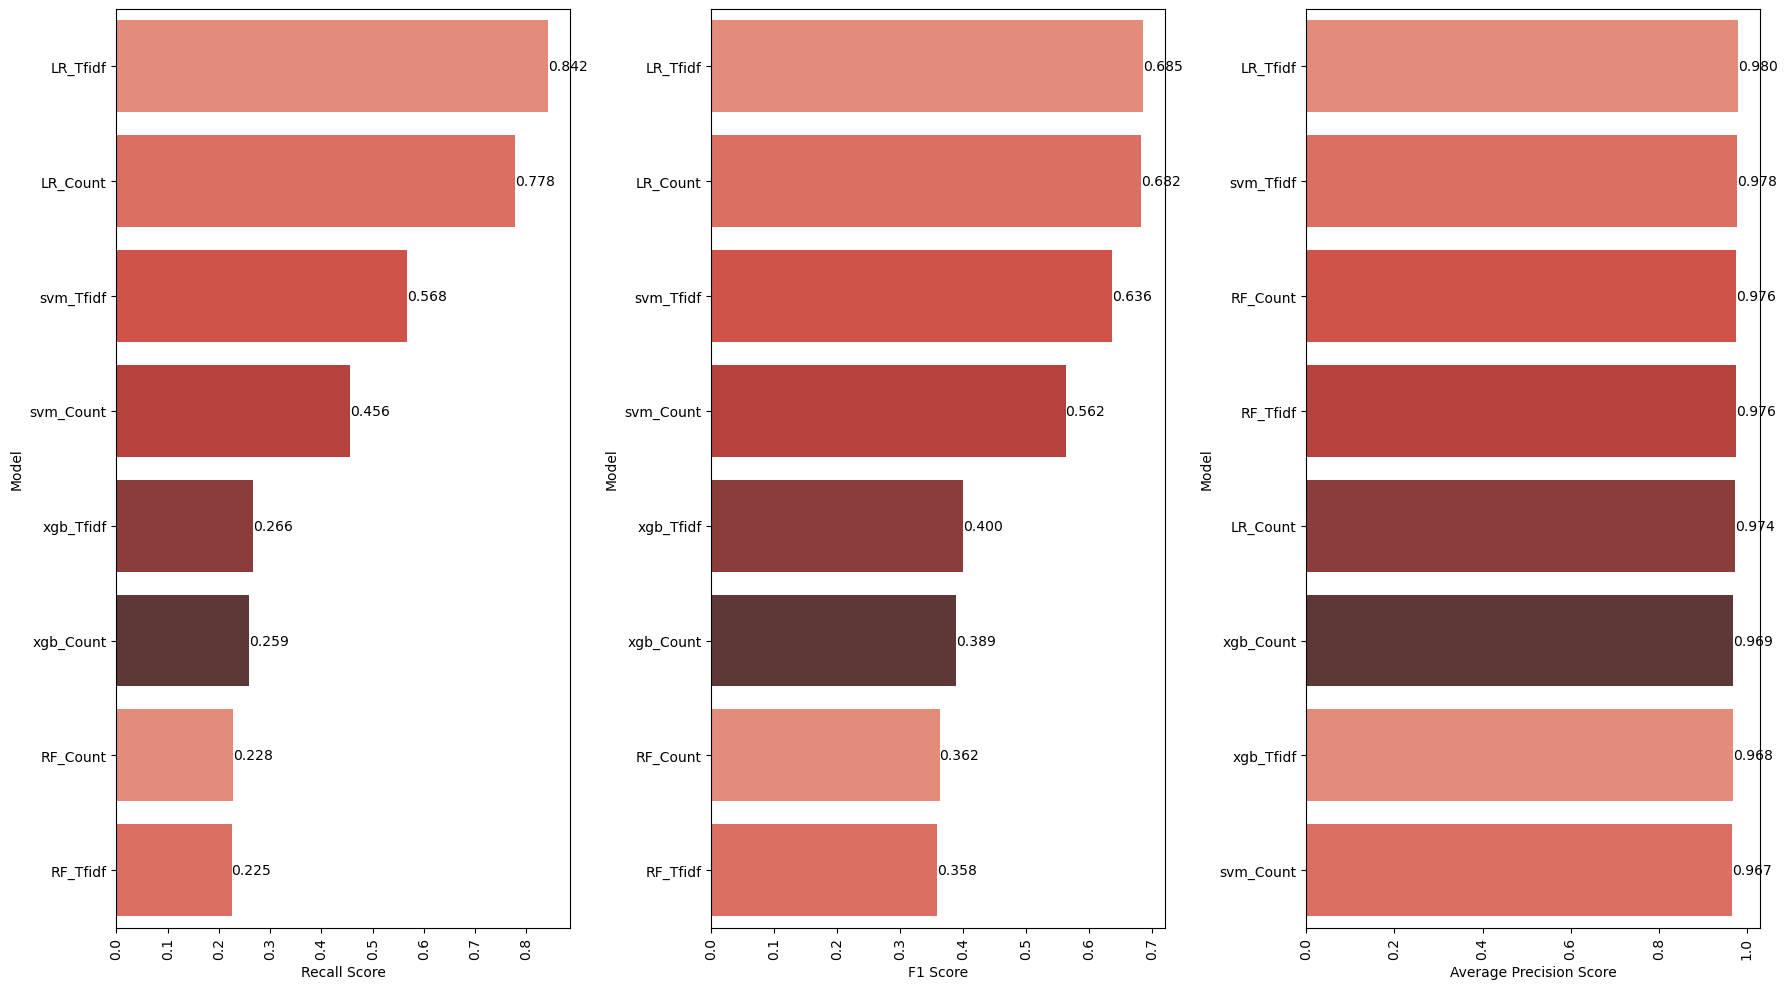

In [53]:
compare = pd.DataFrame({"Model": ["LR_Count", "svm_Count", "RF_Count", "xgb_Count",
                                  "LR_Tfidf", "svm_Tfidf", "RF_Tfidf", "xgb_Tfidf"],
                        "F1_Score": [LR_Count_f1, svm_Count_f1, RF_Count_f1, xgb_Count_f1,
                                    LR_Tfidf_f1, svm_Tfidf_f1, RF_Tfidf_f1, xgb_Tfidf_f1],
                        "Recall_Score": [LR_Count_rec, svm_Count_rec, RF_Count_rec, xgb_Count_rec,
                                        LR_Tfidf_rec, svm_Tfidf_rec, RF_Tfidf_rec, xgb_Tfidf_rec],
                        "Average_Precision_Score": [LR_Count_prec, svm_Count_prec, RF_Count_prec, xgb_Count_prec,
                                                   LR_Tfidf_prec, svm_Tfidf_prec, RF_Tfidf_prec, xgb_Tfidf_prec]})

plt.figure(figsize=(18, 10))
red_palette = sns.color_palette("Reds_d")

plt.subplot(131)
compare = compare.sort_values(by="Recall_Score", ascending=False)
ax = sns.barplot(x="Recall_Score", y="Model", data=compare, palette=red_palette)
ax.set_xlabel("Recall Score")
ax.set_ylabel("Model")
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.subplot(132)
compare = compare.sort_values(by="F1_Score", ascending=False)
ax = sns.barplot(x="F1_Score", y="Model", data=compare, palette=red_palette)
ax.set_xlabel("F1 Score")
ax.set_ylabel("Model")
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.subplot(133)
compare = compare.sort_values(by="Average_Precision_Score", ascending=False)
ax = sns.barplot(x="Average_Precision_Score", y="Model", data=compare, palette=red_palette)
ax.set_xlabel("Average Precision Score")
ax.set_ylabel("Model")
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.tight_layout()
plt.show()

In [33]:
# We obtain great results with Logistic Regression using TF-IDF vectorizer
# We are gonna test this on new examples

TEST

In [35]:
def predict_review(model, vectorizer, review):
    # Nettoyer la review
    cleaned_review = text_cleaning(review)
    
    # Vectorisation de la review nettoyée
    review_vectorized = vectorizer.transform([cleaned_review])
    
    # Prédiction avec le modèle
    prediction = model.predict(review_vectorized)
    
    # Retourner la prédiction (0 pour 'Negative', 1 pour 'Positive')
    return "Positive" if prediction == 1 else "Negative"

In [37]:
review_p = "This is an amazing product! I really loved it."
predict_review(LR_Tfidf, tfidf_vectorizer, review_p)

'Positive'

In [39]:
review_ne = 'This product was so shitty.. I am so disappointed to have bought it. Ill never order on this site again.'
predict_review(LR_Tfidf, tfidf_vectorizer, review_ne)

'Negative'

In [41]:
review_n = "I don t know what to think about this product. It is convenient but not really beautiful"
predict_review(LR_Tfidf, tfidf_vectorizer, review_n)

'Positive'